In [1]:
import os
os.environ["JAX_ENABLE_X64"] = "true"
import sys
sys.path.append('..')
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import EnsembleKalmanFilter_Localisation_Inflation
from jax import config
jax.config.update("jax_enable_x64", True)
import numpy as np
from metrics import *

float64


Initialisation of a twin experiment. 

In [8]:
signal_params = ConfigDict(KDV_params_2_SALT_LEARNING)
ensemble_params = ConfigDict(KDV_params_2_SALT_LEARNING)
signal_params.update(E=1,P=3,noise_magnitude = 0.01,stochastic_advection_basis='sin')
ensemble_params.update(E=32,P=3,noise_magnitude = 0.01,stochastic_advection_basis='sin')

Now we specify the models, by calling the class.

In [9]:
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
ensemble_model = ETD_KT_CM_JAX_Vectorised(ensemble_params)

initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
initial_ensemble = initial_condition(ensemble_model.x, ensemble_params.E, ensemble_params.initial_condition)


In [10]:
observation_spatial_frequency = 32
observation_locations = np.arange(0,signal_model.x.shape[0],observation_spatial_frequency)
observation_noise = 0.1
number_of_observations_time = signal_model.params.nt/32
observation_temporal_frequency = int(ensemble_model.params.nt/number_of_observations_time)

enkf = EnsembleKalmanFilter_Localisation_Inflation(
    n_particles = ensemble_params.E,
    n_steps = observation_temporal_frequency,
    n_dim = initial_signal.shape[-1],
    forward_model = ensemble_model,
    signal_model = signal_model,
    sigma = observation_noise,
    observation_locations = observation_locations,
    inflation_factor=1.0,
    localization_radius=1.0
)

In [11]:
da_steps = number_of_observations_time
key_0 = jax.random.PRNGKey(0)
final, all = enkf.run(initial_ensemble, initial_signal, da_steps, key_0) #the final input is scan length? 
particles, signal, observations = all
from metrics.ensemble import crps_internal, rmse
answer = crps_internal(signal, particles)#(particles,signal)



In [12]:
from jax import grad

def loss_fn(params):
    localization = params
    enkf.localization_radius = localization
    final, all = enkf.run(initial_ensemble, initial_signal, da_steps, key_0)
    particles, signal, _ = all
    crps = crps_internal(signal, particles)
    return jnp.mean(crps)

def loss_fn_2(params):
    inflation, localization = params
    enkf.inflation_factor = inflation
    enkf.localization_radius = localization
    final, all = enkf.run(initial_ensemble, initial_signal, da_steps, key_0)
    particles, signal, _ = all
    rmse = rmse(signal, particles)
    return jnp.mean(rmse)

init_params = jnp.array([0.5])

# Compute gradients
grads = grad(loss_fn)(init_params)
print("Gradient w.r.t localization_radius:", grads)
# Simple gradient descent update


Gradient w.r.t localization_radius: [13143453.15199283]


In [13]:
learning_rate = 0.5
new_params = init_params - learning_rate * grads
print("Updated params (localization_radius):", new_params)

Updated params (localization_radius): [-6571726.07599641]


In [14]:
from jax import jit
jit_loss_fn = jit(loss_fn)
localisation_floor = jnp.linspace(0,1,30)
localisation_landscape = jnp.linspace(0,1,30)
for i in range(len(localisation_landscape)):
    localisation_landscape = localisation_landscape.at[i].set(jit_loss_fn(localisation_floor[i]))

# this requires 128 ensemble members at 256 resolution, with 4000 timesteps and global space time crps calculations, 
# over 100 times at different localisation radii. 

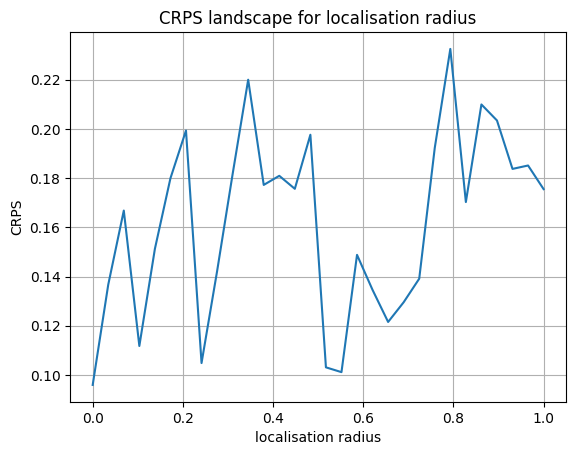

In [15]:
plt.plot(localisation_floor, localisation_landscape)
plt.xlabel('localisation radius')
plt.ylabel('CRPS')
plt.title('CRPS landscape for localisation radius')
plt.grid()

plt.show()

In [ ]:
from jax import jit

# JIT compile the loss and grad functions

jit_loss_fn = jit(loss_fn)
jit_grad_fn = jit(grad(loss_fn))

learning_rate = 0.05
params = init_params
for i in range(100):
    grads = jit_grad_fn(params)
    params = params - learning_rate * grads
    if i % 1 == 0:
        print(f"Step {i}: params = {params}, loss = {jit_loss_fn(params)}")
print("Final learned params:", params)

In [ ]:
import optax
#init_params = jnp.array([enkf.inflation_factor, enkf.localization_radius])
inflation_factor = 1.0
localization_radius = 0.05

enkf_1 = EnsembleKalmanFilter_Localisation_Inflation(
    n_particles = ensemble_params.E,
    n_steps = observation_temporal_frequency,
    n_dim = initial_signal.shape[-1],
    forward_model = ensemble_model,
    signal_model = signal_model,
    sigma = observation_noise,
    observation_locations = observation_locations,
    inflation_factor=inflation_factor,
    localization_radius=localization_radius
)

def loss_fn(params):
    inflation, localization = params
    enkf_1.inflation_factor = inflation
    enkf_1.localization_radius = localization
    final, all = enkf_1.run(initial_ensemble, initial_signal, da_steps, key_0)
    particles, signal, _ = all
    crps = crps_internal(signal, particles)
    return jnp.mean(crps)

jit_loss_fn = jit(loss_fn)
jit_grad_fn = jit(grad(loss_fn))

params = jnp.array([inflation_factor, localization_radius])

loss_history = []
params_history = []

# Set up Adam optimizer
optimizer = optax.adam(learning_rate=0.05)
opt_state = optimizer.init(init_params)
#params = init_params

for i in range(100):
    grads = jit_grad_fn(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    loss = jit_loss_fn(params)
    loss_history.append(loss)
    params_history.append(np.array(params))
    if i % 1 == 0:
        print(f"Step {i}: params = {params}, loss = {loss}")
print("Final learned params:", params)

In [ ]:
time_step = da_steps 
print("Time step shape:", time_step)
def interactive_plot(time_step):
    plt.figure(figsize=(10, 5))
    plt.plot(signal_model.x, signal[time_step, 0, :], color='k', label='signal')
    plt.plot(signal_model.x, particles[time_step, :, :].T, color='b', alpha=0.3, linewidth=0.5, label='particles')
    plt.xlabel('x')
    plt.ylabel('Value')
    plt.title(f'Signal and Particles at time Step {time_step}')
    plt.legend(['signal', 'particles'])
    plt.show()

interact(interactive_plot, time_step=(0, int(da_steps)-1, 1))

Put in the initial condition.